In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:

data_dir = "../dataset/archive/Fruits Classification"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:

def get_dataset_info(dataset):
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Class names: {dataset.classes}")
    print(f"Number of images: {len(dataset)}")
    class_counts = {cls: 0 for cls in dataset.classes}
    for _, label in dataset.samples:
        class_counts[dataset.classes[label]] += 1
    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

print("Training Dataset Info:")
get_dataset_info(train_dataset)
print("Validation Dataset Info:")
get_dataset_info(val_dataset)

Training Dataset Info:
Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of images: 9700
Class distribution:
Apple: 1940
Banana: 1940
Grape: 1940
Mango: 1940
Strawberry: 1940
Validation Dataset Info:
Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of images: 100
Class distribution:
Apple: 20
Banana: 20
Grape: 20
Mango: 20
Strawberry: 20


In [6]:
model = models.resnet50(pretrained=True)

c:\Users\Sara Tel\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sara Tel\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
import time
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        print(epoch)
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")
    end_time = time.time()
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")

In [10]:
def evaluate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

In [11]:
def infer(model, image_path, transform):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    class_name = train_dataset.classes[predicted.item()]
    print(f"Predicted class: {class_name}")
    return class_name

In [29]:
def visualize_predictions(model, val_loader, transform):
    model.eval()
    images, labels = next(iter(val_loader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 10))
    for i in range(15, 24):
        ax = fig.add_subplot(3, 3, i-14, xticks=[], yticks=[])
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Pred: {train_dataset.classes[preds[i].item()]}")
    plt.show()

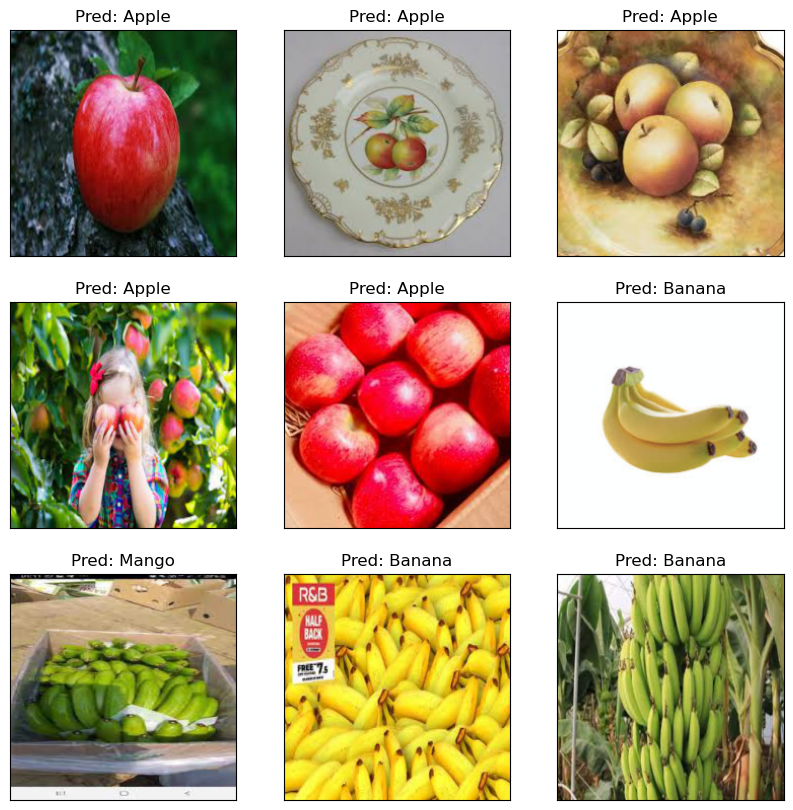

In [30]:
# train(model, train_loader, criterion, optimizer, epochs=5)
# evaluate(model, val_loader, criterion)

visualize_predictions(model, val_loader, transform)

In [26]:
from PIL import Image
image_path = "../dataset/archive/Fruits Classification/test/Mango/Mango (70).jpeg"
infer(model, image_path, transform)

Predicted class: Mango


'Mango'